In [2]:
import sys

sys.path.append('..')

import torch
import models_mae
from collections import OrderedDict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pl_train import Encoder, LightningMAE, get_dino_model

from torch import nn

from util.get_dataloader import get_dataloader

from tqdm import tqdm

In [3]:
activation = nn.Softmax(dim=-1)

In [3]:
annotation_train, annotation_val = '../annotations/cs_train.npy', '../annotations/cs_val.npy'
dataset_name = 'cs'


dataloader, dataloader_val, num_classes, dataset = get_dataloader(dataset_name=dataset_name, \
    train_annotation_file=annotation_train, val_annotation_file=annotation_val, \
    intersection_threshold=0.3, batch_size=1, \
    weighted=False, return_dataset=True, resize_image=False)

In [ ]:
def get_model(deconv=True, upsample=False):

    model_dino = get_dino_model()
    
    encoder = Encoder(model=model_dino, num_classes=33, backbone_freeze=True, 
                      model_name='dino', emb_size=768, deconvolution=deconv,
                      bilinear_upsampling=upsample)
    return encoder.to('cuda')

model_dino = get_model(deconv=False, upsample=True)

In [10]:
ckpt = torch.load('/mnt/lwll/lwll-coral/hrant/mae_checkpoints/cs_dino_bilinear_upsampling_img_test/epoch=299.ckpt')

In [11]:
keys = [i for i in model_dino.state_dict().keys()]

od = OrderedDict()

for key_chpt, key_model in zip(ckpt['state_dict'].keys(), keys):
    if key_model == key_chpt[10:]:
        od[key_model] = ckpt['state_dict'][key_chpt]
    else:
        print(key_model, key_chpt, sep='\t')

# od['a'] = 5
dino = model_dino.load_state_dict(od, strict=False)

In [12]:
dino

<All keys matched successfully>

In [13]:
model_dino.eval()

Encoder(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): La

In [14]:
ebeds_val = []
predictions_val = []
labels_val = []
images = []
for ds in tqdm(dataloader_val, total=len(dataloader_val)):
    img = torch.einsum('nhwc->nchw', ds['image'])
    img_enc = model_dino(img.float().to('cuda'))
    ebeds_val.append(img_enc.to('cpu'))
    img_enc = img_enc.detach().cpu()
    labels_val.append(ds['patch_dino'])
    predictions_val.append(activation(img_enc).argmax(dim=-1).detach().cpu())
    images.extend(ds['file_name'])
    
predictions_val, labels_val = torch.cat(predictions_val, dim=0).cpu(), torch.cat(labels_val, dim=0).cpu()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:30<00:00,  1.03s/it]


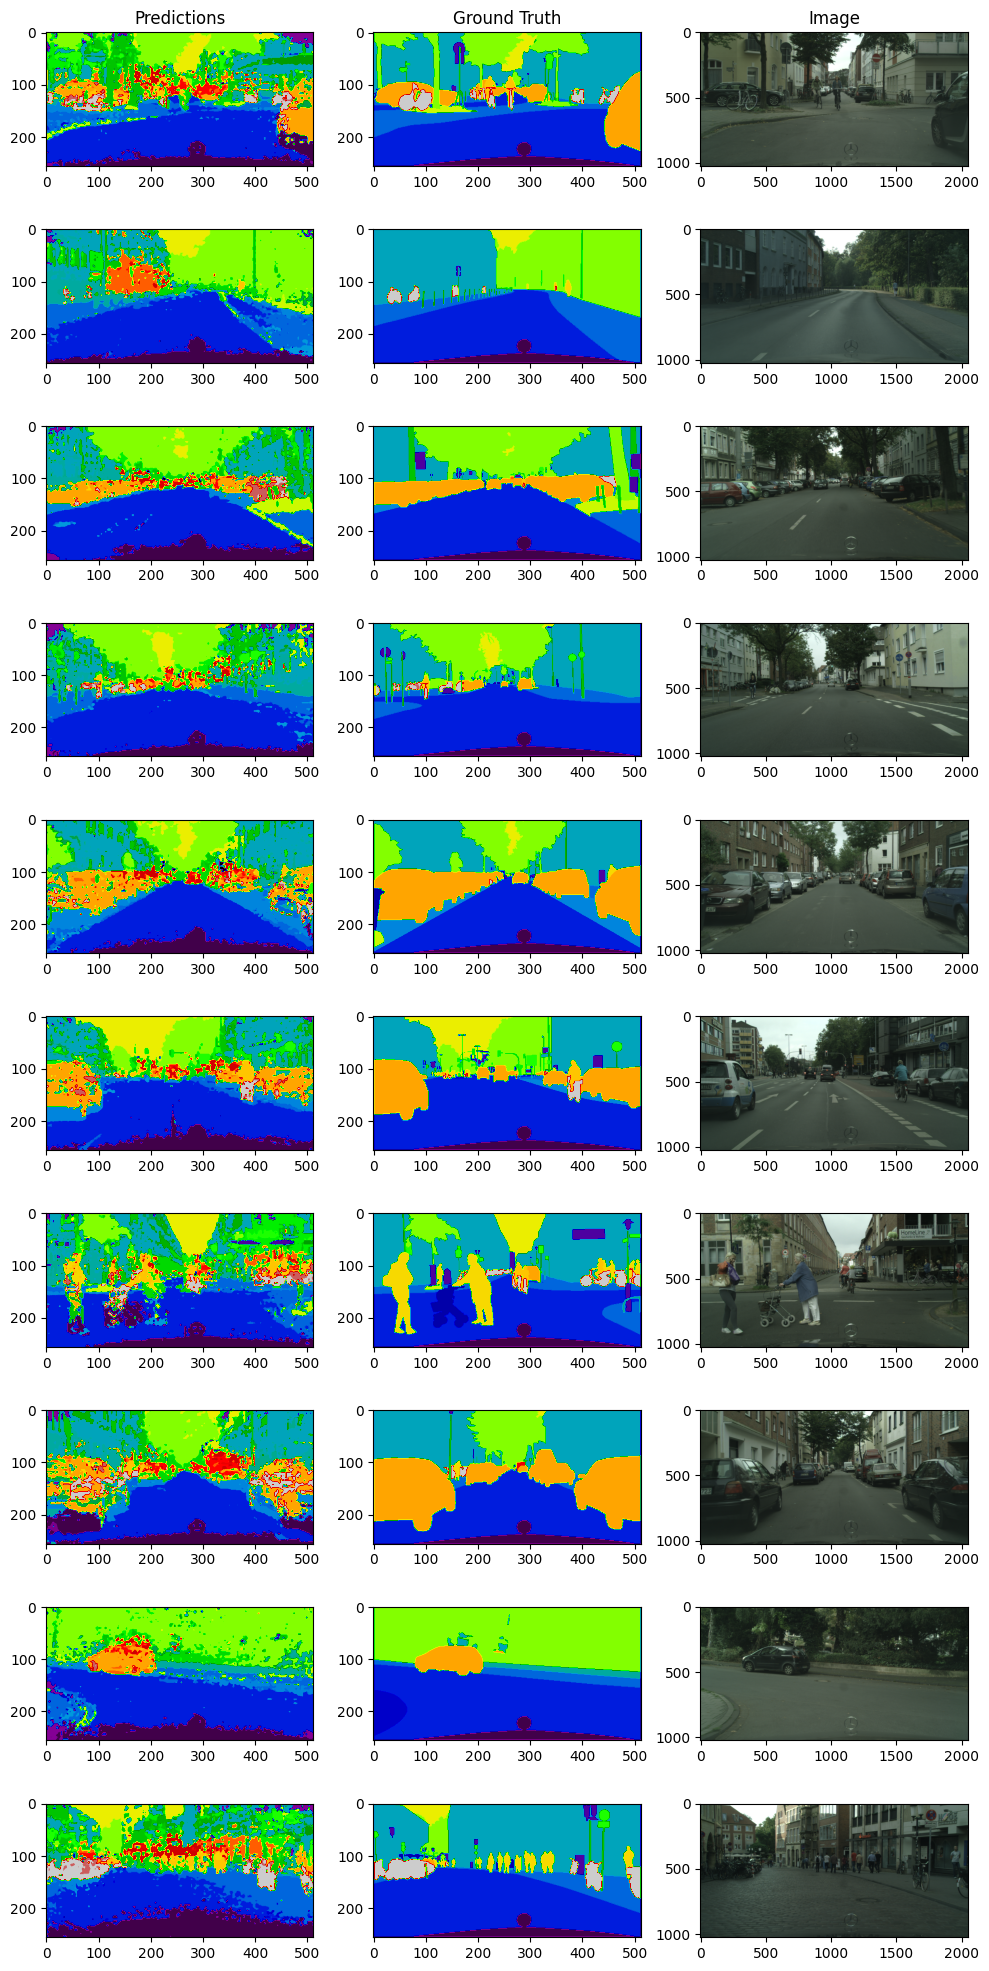

In [29]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 20))
axes[0][0].set_title('Predictions')
axes[0][1].set_title('Ground Truth')
axes[0][2].set_title('Image')
for i in range(10):
    axes[i][0].imshow(predictions_val[i].reshape(256, 512), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][1].imshow(labels_val[i].reshape(256, 512), vmin=0, vmax=num_classes, cmap='nipy_spectral');
    axes[i][2].imshow(np.array(Image.open(images[i])))
plt.tight_layout();

In [20]:
check = np.load('../annotations/eval_cs_dino_epoch=299_bil_usp_img.npy', allow_pickle=True).item()['images']

In [21]:
check[0]

{'file_name': '/mnt/lwll/lwll-coral/hrant/leftImg8bit/val/munster/munster_000097_000019_leftImg8bit.png',
 'height': 1024,
 'width': 2048,
 'id': 0,
 'black_image': array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]], dtype=uint8),
 'patch_labels': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'patch_labels_gt': array([21, 21, 11, 11, 11, 21, 21, 21, 23, 21, 21, 11, 11, 11, 11, 21, 11,
        11,  4, 21, 21, 21, 21, 21, 21, 11, 11, 11, 11, 11, 11, 11, 17, 21,
        21, 23, 11, 21, 11, 11, 11, 11, 11, 11, 11, 11, 17, 21, 11, 23, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 17, 11, 11, 21, 11, 11, 11, 11,
        11, 11, 11, 26, 26, 11, 17, 26,  4, 2

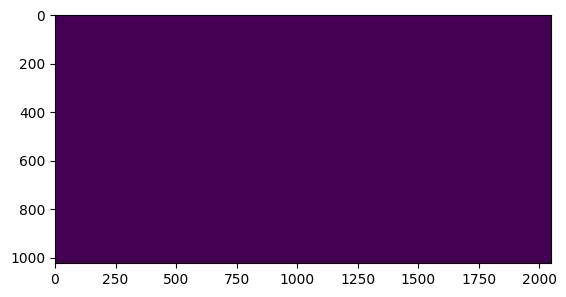

In [22]:
plt.imshow(check[0]['patch_labels']);

In [31]:
import cv2

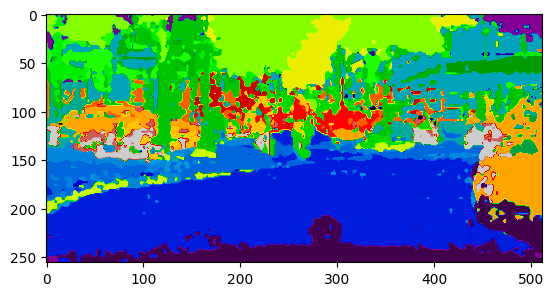

In [32]:
x = predictions_val[0].reshape(256, 512).detach().numpy()
x = cv2.resize(x, (2048, 1024), interpolation=cv2.INTER_NEAREST_EXACT)
plt.imshow(predictions_val[0].reshape(256, 512), vmin=0, vmax=num_classes, cmap='nipy_spectral');

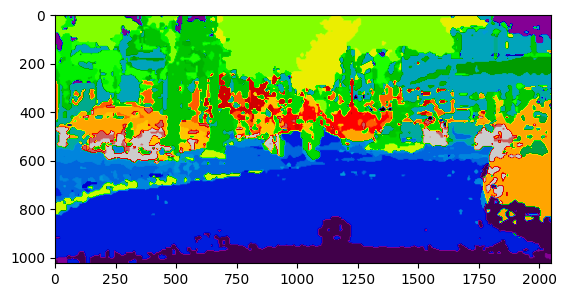

In [33]:
plt.imshow(x, vmin=0, vmax=num_classes, cmap='nipy_spectral');

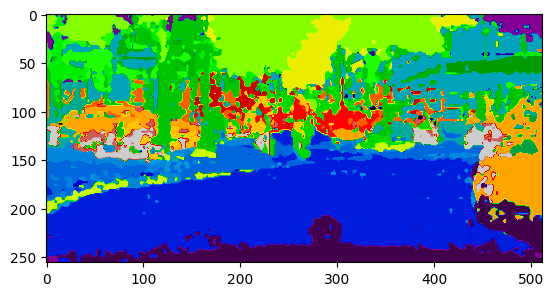

In [30]:
plt.imshow(predictions_val[0].reshape(256, 512), vmin=0, vmax=num_classes, cmap='nipy_spectral');

In [64]:
name = '/home/hkhachatrian/mae/annotations/cs_256_dino_joined_knn_72_train_30_val.npy'
dino = np.load(name, allow_pickle=True)
name = f'/home/hkhachatrian/mae/annotations/cs_256_mae_joined_knn_72_train_30_val.npy'
mae = np.load(name, allow_pickle=True)
name = f'/home/hkhachatrian/mae/annotations/cs_256_sup_vit_joined_knn_72_train_30_val.npy'
sup_vit = np.load(name, allow_pickle=True)

In [65]:
name = '/home/hkhachatrian/mae/annotations/cs_val.npy'
gt = np.load(name, allow_pickle=True).item()['images']

In [ ]:
rows = 10
offset = 5
fig, axes = plt.subplots(nrows=rows, ncols=5, figsize=(25, 32))
plt.suptitle('KNN predictions')
axes[0][0].set_title('Dino')
axes[0][1].set_title('Sup Vit')
axes[0][2].set_title('MAE')
axes[0][3].set_title('GT')
axes[0][4].set_title('Img')
for i in range(rows):
    axes[i][0].imshow(dino[offset + i]['patch_labels'].reshape(1024, 2048), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][1].imshow(sup_vit[offset + i]['patch_labels'].reshape(1024, 2048), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][2].imshow(mae[offset + i]['patch_labels'].reshape(1024, 2048), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][3].imshow(gt[offset + i]['black_image'].reshape(1024, 2048), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][4].imshow(np.array(Image.open(gt[offset + i]['file_name'])))
    
plt.tight_layout()

In [11]:
name = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/dino_val_pred_1nn.npy'
dino = np.load(name, allow_pickle=True).item()['images']
name = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/mae_val_pred_1nn.npy'
mae = np.load(name, allow_pickle=True).item()['images']
name = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/sup_vit_val_pred_1nn.npy'
sup_vit = np.load(name, allow_pickle=True).item()['images']

In [12]:
dino

[{'file_name': '1359__1__0___0.250_1_2.png',
  'height': 250,
  'width': 250,
  'id': 580,
  'black_image': array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'patch_labels': array([2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
name = f'/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/val.npy'
gt = np.load(name, allow_pickle=True).item()['images']

In [14]:
import cv2

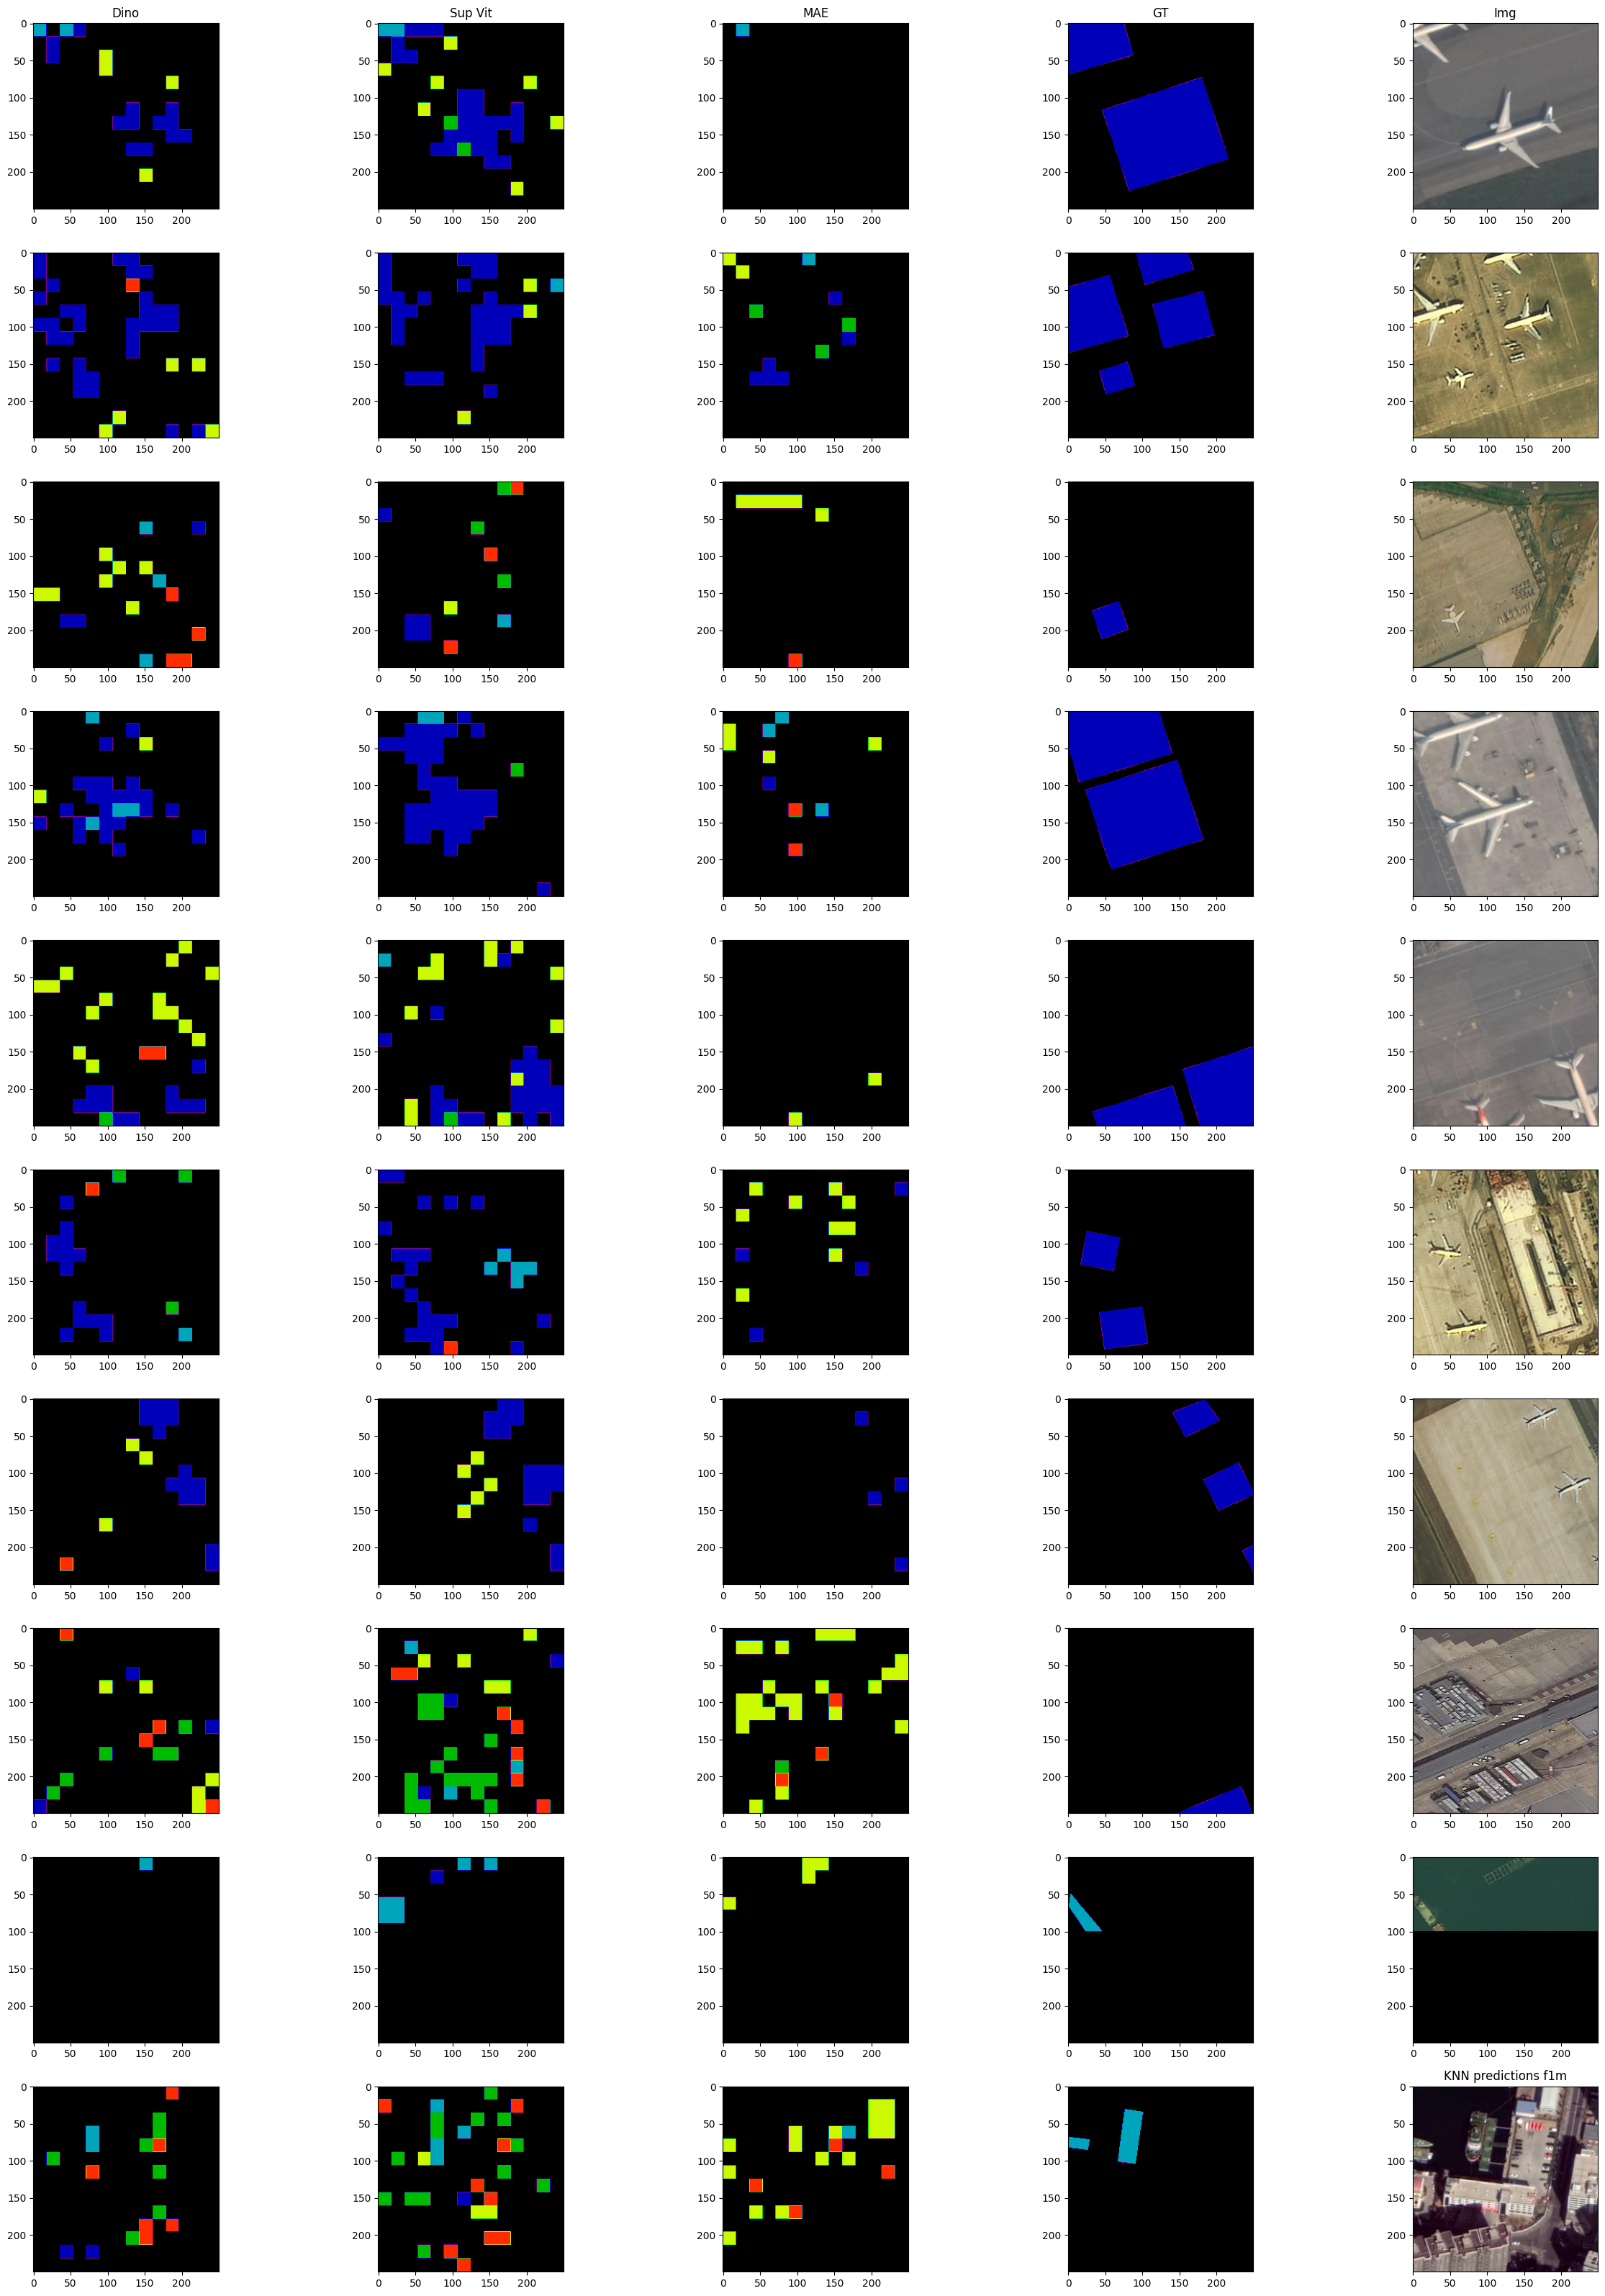

In [27]:
path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/250_8shot/val/images/'
rows = 10
num_classes=6
offset = 0
fig, axes = plt.subplots(nrows=rows, ncols=5, figsize=(25, 32))
# plt.suptitle('KNN predictions f1m')
axes[0][0].set_title('Dino')
axes[0][1].set_title('Sup Vit')
axes[0][2].set_title('MAE')
axes[0][3].set_title('GT')
axes[0][4].set_title('Img')
for i in range(rows):
    resized = cv2.resize(dino[offset + i]['patch_labels'].reshape(14, 14), (250, 250), interpolation=cv2.INTER_NEAREST_EXACT)
    axes[i][0].imshow(resized, vmin=0, vmax=num_classes, cmap='nipy_spectral')
    resized = cv2.resize(sup_vit[offset + i]['patch_labels'].reshape(14, 14), (250, 250), interpolation=cv2.INTER_NEAREST_EXACT)
    axes[i][1].imshow(resized, vmin=0, vmax=num_classes, cmap='nipy_spectral')
    resized = cv2.resize(mae[offset + i]['patch_labels'].reshape(14, 14), (250, 250), interpolation=cv2.INTER_NEAREST_EXACT)
    axes[i][2].imshow(resized, vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][3].imshow(gt[offset + i]['black_image'].reshape(250, 250), vmin=0, vmax=num_classes, cmap='nipy_spectral')
    axes[i][4].imshow(np.array(Image.open(path + gt[offset + i]['file_name'])))
    
plt.tight_layout()

In [18]:
gt[offset + i]['file_name']

'15744__1__0___0.250_2_2.png'